# Precision

```{important}
*spotter* is an **approximate** forward model. Light curves precision is expected to be **no better than 1 ppm** for most practical applications.
```

## Overall precision

The overall light curve precision of *spotter* depends on the resolution of the surface, which depends on the number of HEALPix sides used to describe it. A lower bound on the precision can be simply computed with

In [1]:
import healpy as hp

n_sides = 100
lower_precision = 1/hp.nside2npix(n_sides)

print(f"{lower_precision:.2e}")

8.33e-06


Let's plot the precision for different number of HEALPix sides

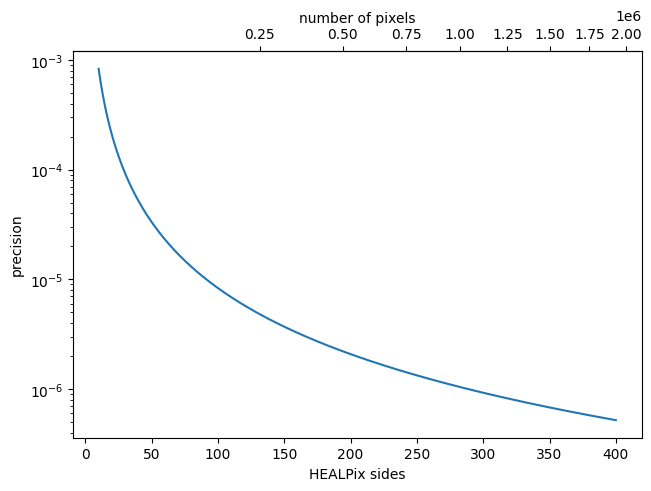

In [16]:
import numpy as np
import matplotlib.pyplot as plt

Ns = np.linspace(10, 400, 1000)
precision = 1/np.vectorize(hp.nside2npix)(Ns)

fig, ax = plt.subplots(layout='constrained')
ax.plot(Ns, precision)
secax = ax.secondary_xaxis('top', functions=(hp.nside2npix, lambda x: np.sqrt(x / 12.0)))
secax.set_xlabel('number of pixels')

plt.yscale("log")
plt.ylabel("precision")
_ = plt.xlabel("HEALPix sides")

## Transit light curves

In order to evaluate transit light curves, *spotter* project the exoplanet disk onto the stellar surface pixels. This leads to high errors depending on the number of HEALPix sides used. 

Let's show the exoplanet pixelated disk for different number of sides.

/Users/lionelgarcia/code/spotter/.venv/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3568: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


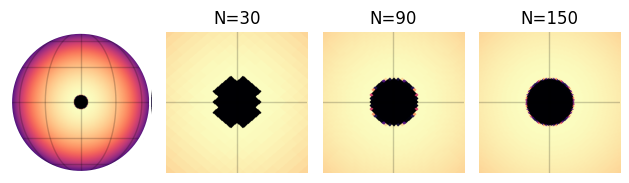

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from spotter import Star, light_curves, viz


star = Star.from_sides(100)
N = np.linspace(30, 150, 3).astype(int)
r = 0.1

plt.subplot(1, len(N)+1, 1)
X = light_curves.transit_design_matrix(Star.from_sides(100), 0, 0, 1, r)
viz.show(X[0])

for i, n in enumerate(N):
    plt.subplot(1, len(N)+1, i+2)
    X = light_curves.transit_design_matrix(Star.from_sides(int(n)), 0, 0, 1, r)
    viz.show(X[0])
    plt.xlim(3*np.array([-1, 1])*r)
    plt.ylim(3*np.array([-1, 1])*r)
    plt.title(f"N={n}")

plt.tight_layout()

Let now see the effect on a light curve precision

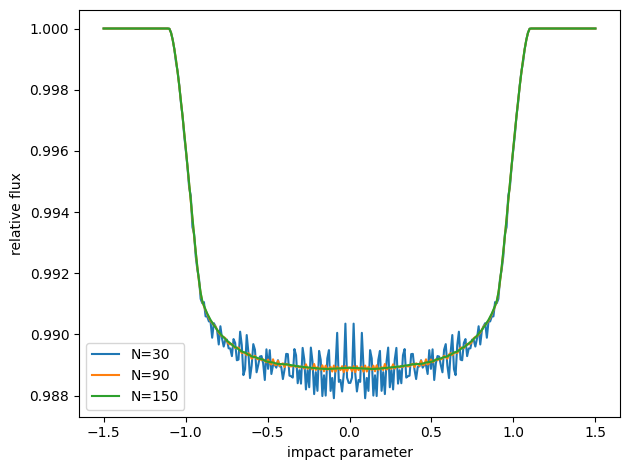

In [22]:
import jax
from spotter import light_curves

# impact parameter
b = np.linspace(-1.5, 1.5, 300)

for i, n in enumerate(N):
    star = star.from_sides(int(n), u=(0.1, 0.4))
    flux = jax.vmap(lambda b:light_curves.transit_light_curve(star, y=b, z=1, r=r))(b)
    plt.plot(b, flux, label=f"N={n}")

plt.legend()
plt.xlabel("impact parameter")
plt.ylabel("relative flux")
plt.tight_layout()

In this case too, the number computed in the last section provides a good **lower bound** on the light curve precision.